In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
from string import punctuation
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as LR
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score 
import math
import nltk
from nltk.corpus import wordnet
% matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
data = pd.read_csv("loan.csv", usecols=("purpose", "title","id"))

In [3]:
#the title column has a short desciption of the borrower's loan. This is the field we will use, but first we need to make sure it is a string. 
data['title'] = data['title'].astype(str)

In [4]:
#creates a list of indexes for all titles under purpose = other. 
other_index = data[data['purpose'] == "other"].index.tolist()

In [5]:
#these are the words that we don't care about in the string and don't want to include
bad_list =['if','the',"on","and","for","my", "to", "a", "off", "pay", "loan", "other", "payoff"]

In [6]:
#This loop provides a list of words contained in each string and the corresponding loan id
key_list = []
word_list=[]
for i in other_index:
    local_list=[]
    #splits string into separate words and creates a list
    local_list = data['title'][i].split()
    for word in local_list:
        #makes word all lowercase
        word = word.lower()   
        #removes any punctuation
        for p in list(punctuation):
            word=word.replace(p,'')
        if word not in bad_list:
            #appends word and loan id lists outside of function above
            word_list.append(word)
            key_list.append(data['id'][i])

In [7]:
#create an empty dataframe
words_df = pd.DataFrame()
#adds the two news lists as columns of the dataframe
words_df['id'] = key_list
words_df['word'] = word_list

In [ ]:
#note: this cell is slow to run
#As a way to visualize what we've done so far, I created a word cloud using our text data

# join tweets to a single string

words = ' '.join(words_df['word'])
#creates the word could
wordcloud = WordCloud(
                      font_path='/Users/lizdeschaine/Library/Fonts/Arial.ttf',
                      background_color='black',
                      width=5000,
                      height=4000
                     ).generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [10]:
#now we want all of the data to merge with our string data frame
full_data = pd.read_csv("loan.csv")
#only use the first 30 columns
full_data = full_data.ix[:,:30]
#merge the two dataframes on 'id'
merge_df = pd.merge(full_data, words_df, on='id')


//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
#Checking to see if the merge worked correctly. If the column "word" is there - it did!
merge_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,word
0,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,personel
1,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,personal
2,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,...,Building my credit history.,774xx,TX,18.08,0.0,Sep-2004,0.0,NaN,NaN,building
3,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,...,Building my credit history.,774xx,TX,18.08,0.0,Sep-2004,0.0,NaN,NaN,credit
4,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,...,Building my credit history.,774xx,TX,18.08,0.0,Sep-2004,0.0,NaN,NaN,history


In [12]:
#This function will create binary variable for the loan status. I assign each classification a "1" or a "0" and then apply it to the column at the end.
def loan_stat_num(x):
    if x == "Charged Off":
        return 0
    if x == "Current":
        return 1
    if x == "Default":
        return 0
    if x == "Does not meet the credit policy. Status:Charged Off":
        return 0
    if x == "Does not meet the credit policy. Status:Fully Paid":
        return 1
    if x == "Fully Paid":
        return 1
    if x == "In Grace Period":
        return 1
    if x == "Issued":
        return 0
    if x == "Late (16-30 days)":
        return 0
    if x == "Late (31-120 days)":
        return 0
merge_df["loan_stat_num"] = merge_df["loan_status"].apply(loan_stat_num)

In [13]:
#Like with loan status, we assign a dummy variable to the loan grades. This was incase we wanted to use grade as our dependent variable. 
def grade_num(x):
    if x == "A":
        return 7
    if x == "B":
        return 6
    if x == "C":
        return 5
    if x == "D":
        return 4
    if x == "E":
        return 3
    if x == "F":
        return 2
    if x == "G":
        return 1
merge_df["grade_num"] = merge_df["grade"].apply(grade_num)

In [14]:
#We first create a new column "cat" for category 
merge_df['cat'] = ""
#The column is empty and will contain a string 
merge_df['cat'] = merge_df['cat'].astype(str)

#Here we employ the NLTK. I learned how to write parts of this code using this sentdex page: https://pythonprogramming.net/wordnet-nltk-tutorial/
def syns(target_word):
    local_list = []
    #the synset will contain a set up lemmas
    for syn in wordnet.synsets(target_word):
        #this appends the word contained in each lemma to the list
        for l in syn.lemmas():
            local_list.append(l.name())
    
    #capturing words not included in the wordnet
    if target_word=='car':
        local_list.append('motorcycle')
    if target_word=='medical':
        local_list.append('dental')
    
    #iterating through each row in the merge_df dataframe to add the captured words to the corresponding synonym
    for i, row in merge_df.iterrows():
        if merge_df['word'][i] in local_list:
            merge_df.set_value(i,'cat',target_word)

#capturing words and their synonyms for the following categories:            
syns('wedding')
syns('home')
syns('car')
syns('medical')
syns('vacation')
syns('business')

In [15]:
#now that we've separated the words in the string, identified synonyms, and linked it back to the dataframe,
#these are the categories to be used for our analysis
category_list = ["home", "wedding", "medical", "business", "car", "vacation"]

In [17]:
#new dataframe containing only the data we have categorized for our analysis
cat = merge_df.loc[merge_df['cat'] != ""]
cat['int_rate'].dropna()
cat['dti'].dropna()
cat['loan_amnt'].dropna()
cat['loan_stat_num'].dropna()

8        1
16       1
22       1
47       1
49       1
54       0
57       0
59       0
69       1
73       1
83       1
96       1
101      1
102      0
104      1
109      1
111      1
123      1
147      1
151      1
153      1
157      1
166      1
176      1
178      1
181      1
194      1
196      0
198      1
200      1
        ..
18459    1
18463    1
18466    1
18470    1
18479    1
18485    1
18487    1
18489    1
18493    1
18505    1
18524    0
18528    1
18529    1
18544    1
18551    0
18559    1
18592    1
18605    1
18610    1
18614    1
18633    1
18635    1
18668    1
18685    1
18687    1
18691    1
18699    1
18701    1
18707    1
18748    1
Name: loan_stat_num, dtype: int64

# Logistic Regression Model and Function

In [18]:
def Loan_Function():
    goodAnswer=False
    #this while loop will continue until goodAnswer is true
    while(goodAnswer!=True):
        Q1 = input("Please choose a loan category: home, wedding, medical, business, car, vacation:" )
        if Q1.lower() in category_list:
            #loop stops because user chose word in category list
            goodAnswer=True
            #makes the word lowercase
            Q1 = Q1.lower()
            #makes a copy of the dataframe inside the function so that it does not modify the actual dataframe
            df = cat.copy(deep=True)
            #subsets the dataframe based on whatever the user selected in the first question "Q1"
            df_cat = df.loc[df['cat'] == Q1]
            
            #separate testing and training data
            #splits the data set using 70% for training and 30% for testing
            Train, Test = train_test_split(df_cat, test_size=0.30, random_state=42)
            #our independent variable is interest rate
            xTrain =Train[["int_rate", "dti" ,"loan_amnt"]]
            xTest = Test[["int_rate", "dti" ,"loan_amnt"]]
            #dependent variable is loan status binary variable created in the function above
            yTrain = Train["loan_stat_num"]
            yTest = Test["loan_stat_num"]
            yTrain = yTrain.astype(np.float)
            yTest  = yTest.astype(np.float)

            
            #build model
            #we use logisitic regression because we are going to predict a binary outcome variable
            Model = LR(class_weight="balanced")
            Model.fit(xTrain, yTrain)
            yPredTest = Model.predict(xTest)
            A = Model.coef_[0]
            b = Model.intercept_

            print (accuracy_score(yPredTest, yTest))
            
            #this function will be useful below in the case the user does not input a number for interest rate
            def is_number(Q2):
                try:
                    float(Q2)
                    return True
                except ValueError:
                    return False
            
            Input = []
            
            Q2=''
            #this while loop will continue until is_number is true
            while (is_number(Q2) == False):
                Q2 = input("What is the interest rate of the loan? ")
                
            Q3=''
            #this while loop will continue until is_number is true
            while (is_number(Q3) == False):
                Q3 = input("What is the dti for the loan? ")
                
            Q4=''
            #this while loop will continue until is_number is true
            while (is_number(Q4) == False):
                Q4 = input("What is the loan amount for the loan? ")
            
            #to account for user entering decimal instead of integer
            int_rate = float(Q2)
            if int_rate < 1:
                int_rate =  int_rate*100
            
            dti = float(Q3)
            loan_amnt = float(Q4)
            
            Input.append(int_rate)
            Input.append(dti)
            Input.append(loan_amnt)
            
            my_arr = np.array(Input)
            my_arr = my_arr.reshape(1,-1)            
                        
            #Predicts the probability of success and failure given our model
            prediction = Model.predict(my_arr)
            if prediction == 1:
                print ("We predict this loan will succeed")
            if prediction == 0:
                print ("We predict this loan will fail")
            
            X = Model.predict_proba(my_arr)
            if (prediction == 1):
                print("\nFor loans in the {0} category, at an interest rate of {1}%, dti of {3}, and loan amount of {4}: \nThe loan will succeed with an accuracy rate of {2}".format(Q1,int_rate,X[:,1],dti,loan_amnt))
            elif (prediction == 0):
                print("\nFor loans in the {0} category, at an interest rate of {1}%, dti of {3}, and loan amount of {4}: \nThe loan will fail with an accuracy rate of {2}".format(Q1,int_rate,X[:,0],dti,loan_amnt))
            else:
                print("Not possible")
            #print ("For loans in the {0} category, at an interest rate of {1}%: \nthe probability of success is {2} \nand probability of failure is {3}".format(Q1,int_rate,X[:,0]))
            
        else:
            print ("That is not a possible category. Please check your spelling or choose again!")

In [ ]:
Loan_Function()

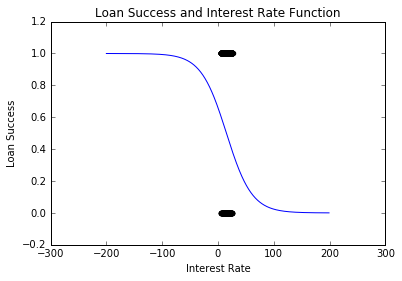

In [19]:
#plotting our logisitic regression function using interest rate and all of our categorized data

            
Train, Test = train_test_split(cat, test_size=0.30, random_state=42)
xTrain =Train[["int_rate"]]
xTest = Test[["int_rate"]]
yTrain = Train["loan_stat_num"]
yTest = Test["loan_stat_num"]
yTrain = yTrain.astype(np.float)
yTest  = yTest.astype(np.float)

Model = LR(class_weight="balanced")
Model.fit(xTrain, yTrain)
yPredTest = Model.predict(xTest)
A = Model.coef_[0]
b = Model.intercept_

plt.scatter(xTrain, yTrain, color='black', zorder=20)
X1 = []
y = []


for x in range(-200,200,1):
    y.append(1/(1+(math.exp(-(A*x+b)))))
    X1.append(x)
    
plt.plot(X1,y)
plt.ylabel('Loan Success')
plt.xlabel('Interest Rate')
plt.title('Loan Success and Interest Rate Function')
plt.show()




# SVM Model and Function

In [20]:
#Building a SVM Model
df = cat.copy(deep=True)

In [21]:
Data10 = df.loc[df["loan_stat_num"]== 0]
Data10.shape

(328, 34)

In [22]:
Data20 = df.loc[df["loan_stat_num"]== 1]
Data20.shape

(1592, 34)

In [23]:
from sklearn import datasets
from sklearn import svm
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [24]:
frames = [Data10, Data20]

In [25]:
Data4 = pd.concat(frames)

In [26]:
Data5 = Data4[["int_rate","loan_amnt"]]

In [27]:
Data6 = Data4["loan_stat_num"]

In [28]:
Data5.shape

(1920, 2)

In [29]:
xTrain, xTest, yTrain, yTest = train_test_split(Data5, Data6, test_size=0.30, random_state=42)

In [30]:
svm_model2 = svm.SVC(kernel='rbf', gamma=0.05, C=16, class_weight='balanced')

In [31]:
svm_model2.fit(xTrain, yTrain)

SVC(C=16, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
svm_ypred2 = svm_model2.predict(xTest)

In [33]:
print(metrics.confusion_matrix(yTest, svm_ypred2))

[[ 37  54]
 [166 319]]


In [ ]:
plt.figure(figsize = (20,20))
plt.scatter(xTrain.ix[:, 0], xTrain.ix[:, 1], c = yTrain, s = 100)
smoothness = .2
x_min, x_max = xTrain.ix[:, 0].min() - 10, xTrain.ix[:, 0].max() + 10
y_min, y_max = xTrain.ix[:, 1].min() - 10, xTrain.ix[:, 1].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, smoothness), np.arange(y_min, y_max, smoothness))
Z = svm_model2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, s = 2, alpha=0.5)
plt.show()